# 1

Total samples in dataset: 988


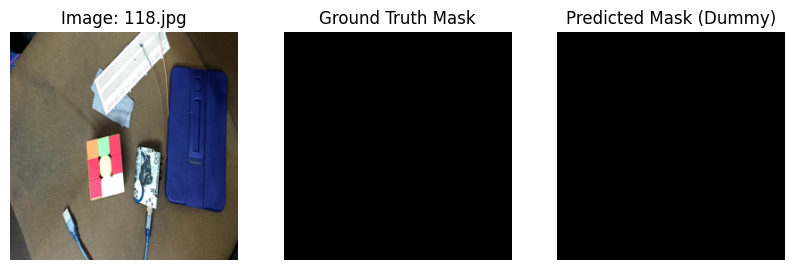

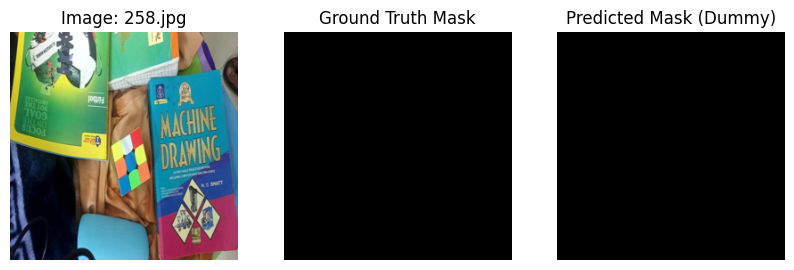

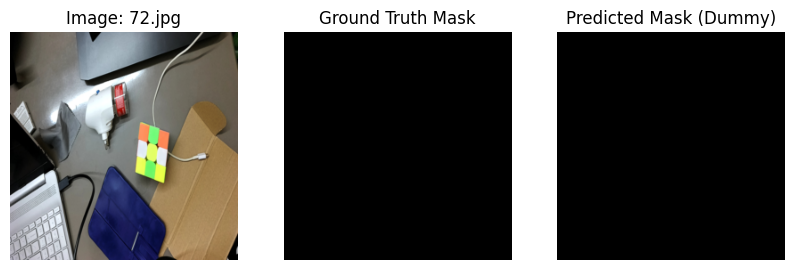

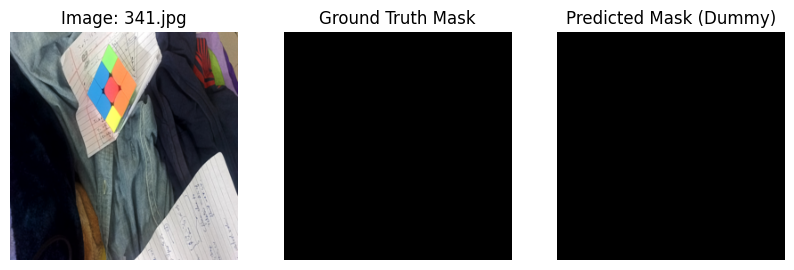

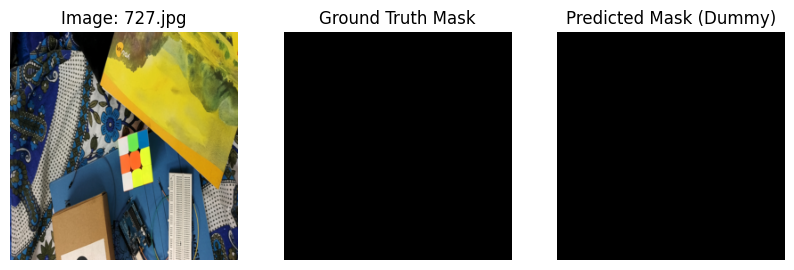

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
import random

# 1. Custom Dataset Class
class RubiksCubeDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels')
        
        self.image_files = sorted([
            f for f in os.listdir(self.images_dir) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
        ])
        
        self.label_files = []
        for img_file in self.image_files:
            label_file = img_file.rsplit('.', 1)[0] + '.txt'
            label_path = os.path.join(self.labels_dir, label_file)
            if os.path.isfile(label_path):
                self.label_files.append(label_file)
            else:
                print(f"Warning: Label file {label_file} not found for image {img_file}. Skipping this image.")
        
        self.image_files = [f for f in self.image_files if f.replace('.jpg', '.txt') in self.label_files]
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label_name = self.label_files[idx]
        
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        label_path = os.path.join(self.labels_dir, label_name)
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = parts[0]
                if class_id != '0':
                    continue
                try:
                    x1_norm, y1_norm, x2_norm, y2_norm = map(float, parts[1:5])
                    x1 = int(x1_norm * width)
                    y1 = int(y1_norm * height)
                    x2 = int(x2_norm * width)
                    y2 = int(y2_norm * height)
                    
                    x1, x2 = max(0, min(x1, width - 1)), max(0, min(x2, width - 1))
                    y1, y2 = max(0, min(y1, height - 1)), max(0, min(y2, height - 1))
                    
                    cv2.rectangle(mask, (x1, y1), (x2, y2), color=1, thickness=-1)
                except ValueError:
                    print(f"Invalid label format in file {label_name}: '{line}'")
            else:
                print(f"Incomplete label information in file {label_name}: '{line}'")
        
        mask = Image.fromarray(mask)
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask, img_name  # Returning img_name for reference

# 2. Define Transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# 3. Initialize Dataset
dataset = RubiksCubeDataset(
    root_dir='archive',  # Update this path if necessary
    transform=image_transforms,
    mask_transform=mask_transforms
)

print(f"Total samples in dataset: {len(dataset)}")

# 4. Visualization Functions
def denormalize(image_tensor, mean, std):
    """
    Denormalizes a tensor image using mean and std.
    """
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

def visualize_samples(dataset, num_samples=5):
    """
    Visualizes a specified number of samples from the dataset.
    
    Args:
        dataset (Dataset): The dataset to visualize from.
        num_samples (int): Number of samples to visualize.
    """
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        image, mask, img_name = dataset[idx]
        
        # Denormalize image for visualization
        image_vis = denormalize(image.clone(), mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        image_vis = image_vis.permute(1, 2, 0).numpy()
        image_vis = np.clip(image_vis, 0, 1)
        
        # Convert mask to numpy
        mask_np = mask.squeeze().numpy()
        mask_np = (mask_np > 0.5).astype(np.float32)
        
        # Plotting
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 3, 1)
        plt.title(f'Image: {img_name}')
        plt.imshow(image_vis)
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask')
        plt.imshow(mask_np, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask (Dummy)')
        plt.imshow(mask_np, cmap='gray')  # Placeholder for actual predictions
        plt.axis('off')
        
        plt.show()

# 5. Visualize Samples
visualize_samples(dataset, num_samples=5)

# 2

Total samples in dataset: 988


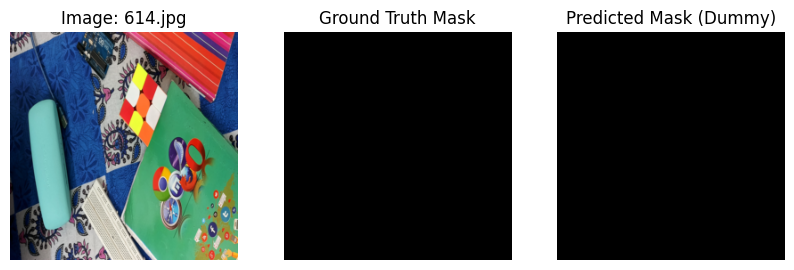

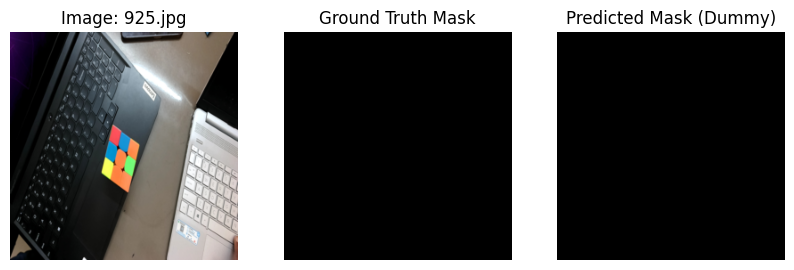

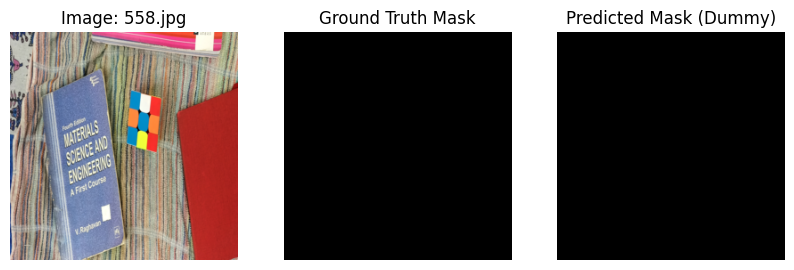

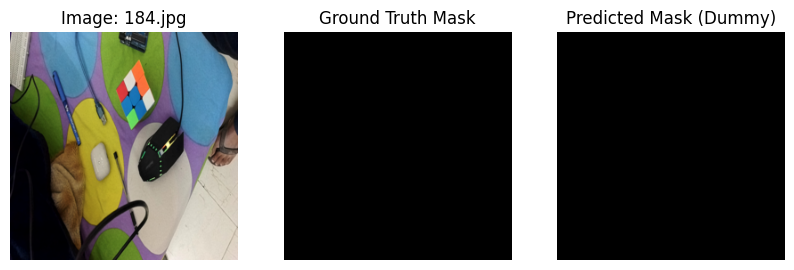

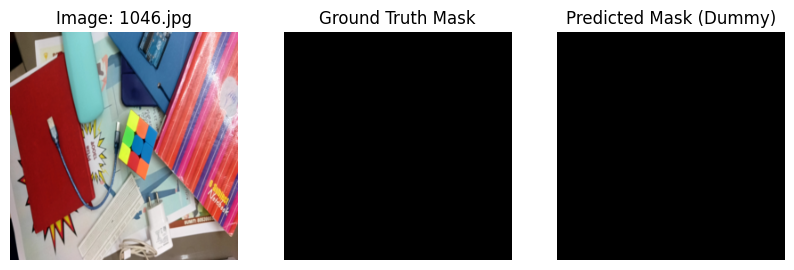

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
import random

# 1. Custom Dataset Class
class RubiksCubeDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels')
        
        self.image_files = sorted([
            f for f in os.listdir(self.images_dir) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
        ])
        
        self.label_files = []
        for img_file in self.image_files:
            label_file = img_file.rsplit('.', 1)[0] + '.txt'
            label_path = os.path.join(self.labels_dir, label_file)
            if os.path.isfile(label_path):
                self.label_files.append(label_file)
            else:
                print(f"Warning: Label file {label_file} not found for image {img_file}. Skipping this image.")
        
        self.image_files = [f for f in self.image_files if f.replace('.jpg', '.txt') in self.label_files]
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label_name = self.label_files[idx]
        
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        label_path = os.path.join(self.labels_dir, label_name)
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = parts[0]
                if class_id != '0':
                    continue
                try:
                    x1_norm, y1_norm, x2_norm, y2_norm = map(float, parts[1:5])
                    x1 = int(x1_norm * width)
                    y1 = int(y1_norm * height)
                    x2 = int(x2_norm * width)
                    y2 = int(y2_norm * height)
                    
                    x1, x2 = max(0, min(x1, width - 1)), max(0, min(x2, width - 1))
                    y1, y2 = max(0, min(y1, height - 1)), max(0, min(y2, height - 1))
                    
                    cv2.rectangle(mask, (x1, y1), (x2, y2), color=1, thickness=-1)
                except ValueError:
                    print(f"Invalid label format in file {label_name}: '{line}'")
            else:
                print(f"Incomplete label information in file {label_name}: '{line}'")
        
        mask = Image.fromarray(mask)
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask, img_name  # Returning img_name for reference

# 2. Define Transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# 3. Initialize Dataset
dataset = RubiksCubeDataset(
    root_dir='archive',  # Update this path if necessary
    transform=image_transforms,
    mask_transform=mask_transforms
)

print(f"Total samples in dataset: {len(dataset)}")

# 4. Visualization Functions
def denormalize(image_tensor, mean, std):
    """
    Denormalizes a tensor image using mean and std.
    """
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

def visualize_samples(dataset, num_samples=5):
    """
    Visualizes a specified number of samples from the dataset.
    
    Args:
        dataset (Dataset): The dataset to visualize from.
        num_samples (int): Number of samples to visualize.
    """
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        image, mask, img_name = dataset[idx]
        
        # Denormalize image for visualization
        image_vis = denormalize(image.clone(), mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        image_vis = image_vis.permute(1, 2, 0).numpy()
        image_vis = np.clip(image_vis, 0, 1)
        
        # Convert mask to numpy
        mask_np = mask.squeeze().numpy()
        mask_np = (mask_np > 0.5).astype(np.float32)
        
        # Plotting
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 3, 1)
        plt.title(f'Image: {img_name}')
        plt.imshow(image_vis)
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask')
        plt.imshow(mask_np, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask (Dummy)')
        plt.imshow(mask_np, cmap='gray')  # Placeholder for actual predictions
        plt.axis('off')
        
        plt.show()

# 5. Visualize Samples
visualize_samples(dataset, num_samples=5)

# 3

Found 988 image-label pairs.
Training samples: 790
Testing samples: 198
Visualizing training samples...


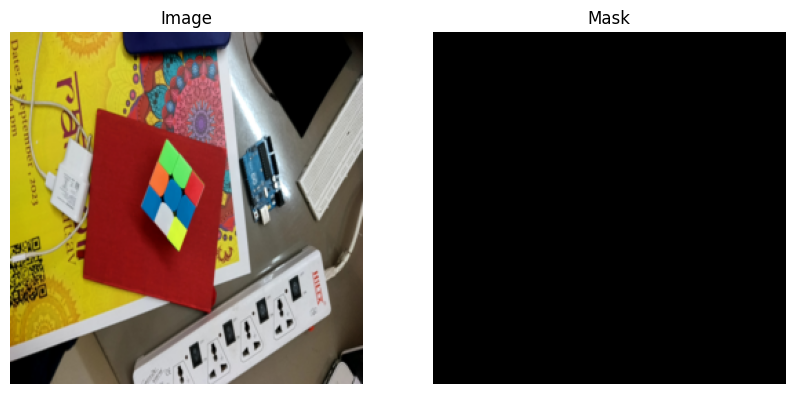

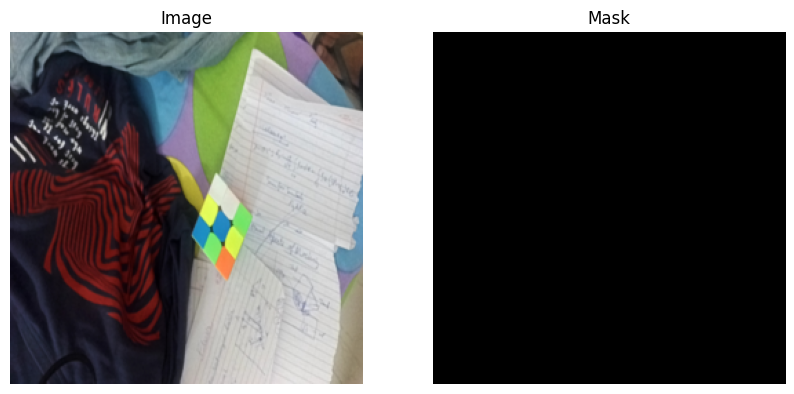

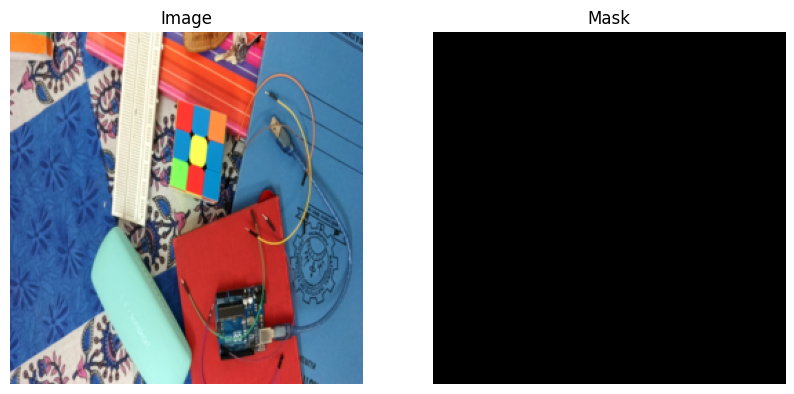

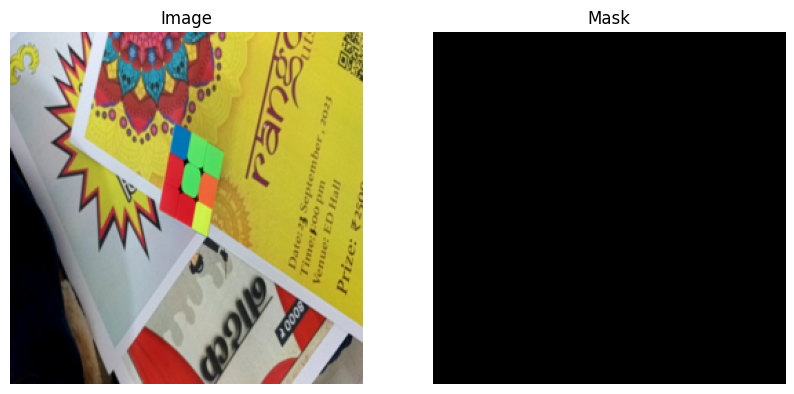

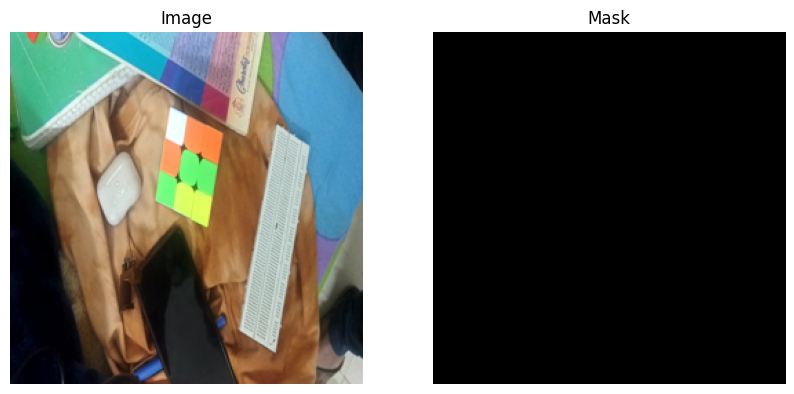

Visualizing testing samples...


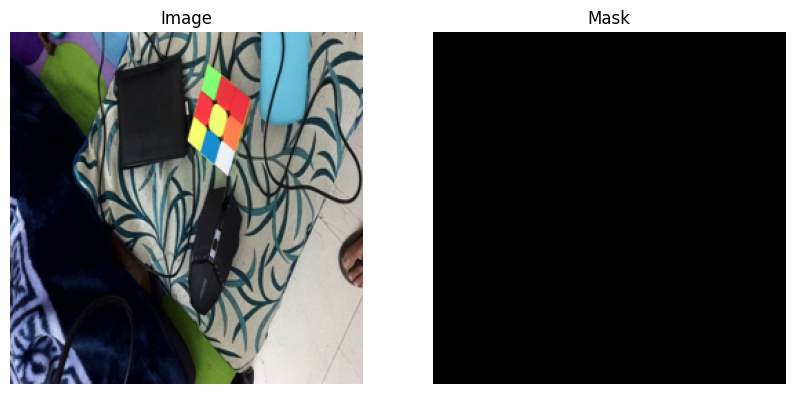

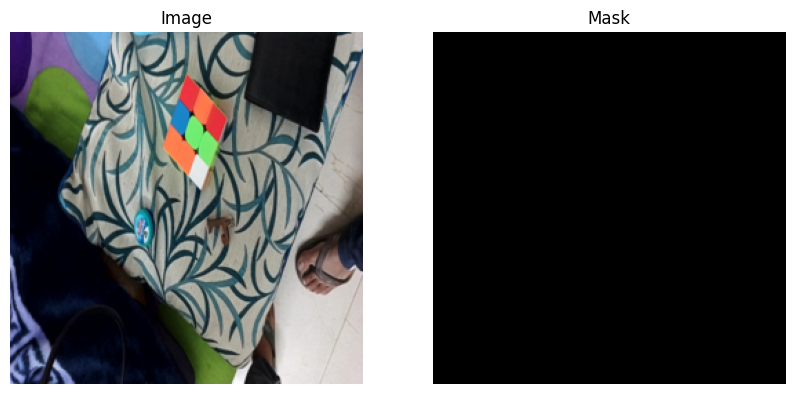

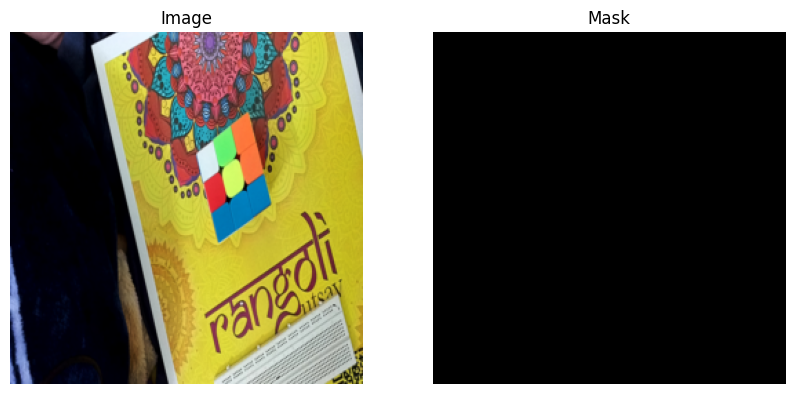

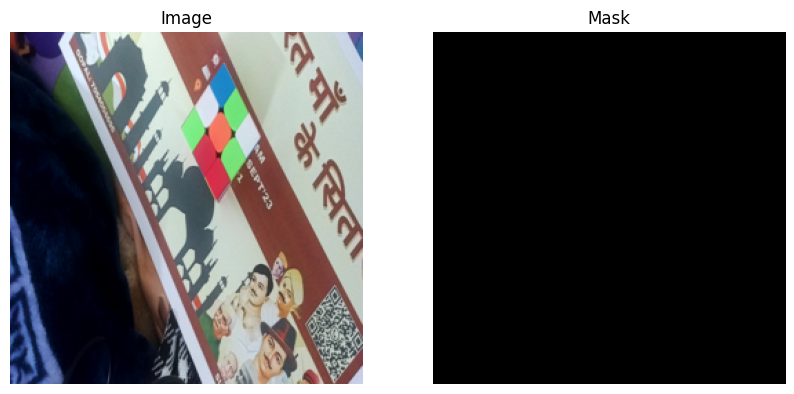

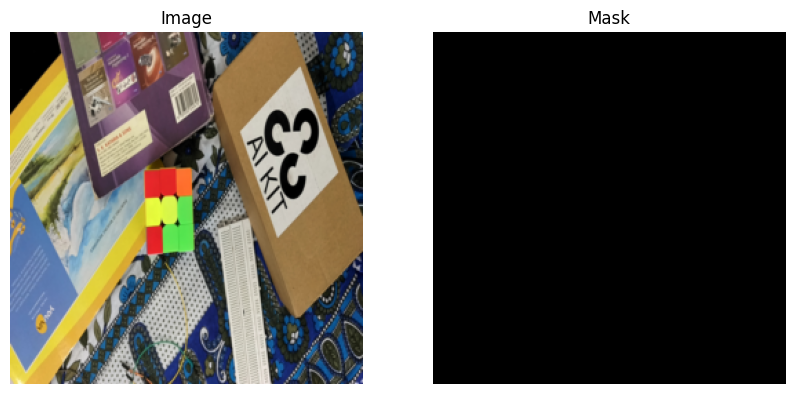

In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
import re
import random

# Helper Function
def extract_number(filename):
    """
    Extracts the numerical part from a filename.
    For example, '2.jpg' returns 2.
    """
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        return -1  # Return -1 if no number is found

# Custom Dataset Class
class RubiksCubeDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Directory with 'images' and 'labels' folders.
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels')
        
        # List all image and label files
        image_files = [
            f for f in os.listdir(self.images_dir) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
        ]
        label_files = [
            f for f in os.listdir(self.labels_dir) 
            if f.lower().endswith('.txt')
        ]
        
        # Extract numbers and create dictionaries
        image_dict = {extract_number(f): f for f in image_files}
        label_dict = {extract_number(f): f for f in label_files}
        
        # Find common keys to ensure pairing
        common_keys = sorted(list(set(image_dict.keys()) & set(label_dict.keys())))
        
        if not common_keys:
            raise ValueError("No matching image and label files found.")
        
        # Create sorted lists based on numerical order
        self.image_files = [image_dict[k] for k in common_keys]
        self.label_files = [label_dict[k] for k in common_keys]
        
        self.transform = transform
        self.mask_transform = mask_transform
        
        print(f"Found {len(self.image_files)} image-label pairs.")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Get image and label filenames
        img_name = self.image_files[idx]
        label_name = self.label_files[idx]
        
        # Full paths
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, label_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        # Load and parse label
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Initialize mask
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = parts[0]
                if class_id != '0':
                    continue  # Skip other classes if any
                try:
                    # Parse normalized coordinates
                    x1_norm, y1_norm, x2_norm, y2_norm = map(float, parts[1:5])
                    
                    # Convert to pixel coordinates
                    x1 = int(x1_norm * width)
                    y1 = int(y1_norm * height)
                    x2 = int(x2_norm * width)
                    y2 = int(y2_norm * height)
                    
                    # Ensure coordinates are within image boundaries
                    x1, x2 = max(0, min(x1, width - 1)), max(0, min(x2, width - 1))
                    y1, y2 = max(0, min(y1, height - 1)), max(0, min(y2, height - 1))
                    
                    # Draw filled rectangle on mask
                    cv2.rectangle(mask, (x1, y1), (x2, y2), color=1, thickness=-1)
                except ValueError:
                    print(f"Invalid label format in file {label_name}: '{line}'")
            else:
                print(f"Incomplete label information in file {label_name}: '{line}'")
        
        # Convert mask to PIL Image
        mask = Image.fromarray(mask)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask

# Define Transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# Initialize Dataset
try:
    dataset = RubiksCubeDataset(
        root_dir='archive',  # Update this path if necessary
        transform=image_transforms,
        mask_transform=mask_transforms
    )
except ValueError as ve:
    print(ve)
    exit(1)

# Split into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Visualization Functions
def denormalize(image_tensor, mean, std):
    """
    Denormalizes a tensor image using mean and std.
    """
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

def visualize_samples(dataset, num_samples=5):
    """
    Visualizes a specified number of samples from the dataset.
    
    Args:
        dataset (Dataset): The dataset to visualize from.
        num_samples (int): Number of samples to visualize.
    """
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        image, mask = dataset[idx]
        
        # Denormalize image for visualization
        image_vis = denormalize(image.clone(), mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        image_vis = image_vis.permute(1, 2, 0).numpy()
        image_vis = np.clip(image_vis, 0, 1)
        
        # Convert mask to numpy
        mask_np = mask.squeeze().numpy()
        mask_np = (mask_np > 0.5).astype(np.float32)
        
        # Plotting
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(image_vis)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('Mask')
        plt.imshow(mask_np, cmap='gray')
        plt.axis('off')
        
        plt.show()

# Visualize samples from the training set
print("Visualizing training samples...")
visualize_samples(train_dataset, num_samples=5)

# Visualize samples from the testing set
print("Visualizing testing samples...")
visualize_samples(test_dataset, num_samples=5)

# 4

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
import re
import random

# Helper Function
def extract_number(filename):
    """
    Extracts the numerical part from a filename.
    For example, '2.jpg' returns 2.
    """
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        return -1  # Return -1 if no number is found

# Custom Dataset Class
class RubiksCubeDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Directory with 'images' and 'labels' folders.
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels')
        
        # List all image and label files
        image_files = [
            f for f in os.listdir(self.images_dir) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
        ]
        label_files = [
            f for f in os.listdir(self.labels_dir) 
            if f.lower().endswith('.txt')
        ]
        
        # Extract numbers and create dictionaries
        image_dict = {extract_number(f): f for f in image_files}
        label_dict = {extract_number(f): f for f in label_files}
        
        # Find common keys to ensure pairing
        common_keys = sorted(list(set(image_dict.keys()) & set(label_dict.keys())))
        
        if not common_keys:
            raise ValueError("No matching image and label files found.")
        
        # Create sorted lists based on numerical order
        self.image_files = [image_dict[k] for k in common_keys]
        self.label_files = [label_dict[k] for k in common_keys]
        
        self.transform = transform
        self.mask_transform = mask_transform
        
        print(f"Found {len(self.image_files)} image-label pairs.")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Get image and label filenames
        img_name = self.image_files[idx]
        label_name = self.label_files[idx]
        
        # Full paths
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, label_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        # Load and parse label
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Initialize mask
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = parts[0]
                if class_id != '0':
                    continue  # Skip other classes if any
                try:
                    # Parse YOLO format: class_id x_center y_center width height
                    x_center_norm, y_center_norm, box_width_norm, box_height_norm = map(float, parts[1:5])
                    
                    # Convert normalized coordinates to pixel values
                    x_center = int(x_center_norm * width)
                    y_center = int(y_center_norm * height)
                    box_width = int(box_width_norm * width)
                    box_height = int(box_height_norm * height)
                    
                    # Enforce square by taking the smaller dimension
                    min_dim = min(box_width, box_height)
                    half_min_dim = min_dim // 2
                    
                    # Calculate top-left and bottom-right coordinates for square
                    x1 = x_center - half_min_dim
                    y1 = y_center - half_min_dim
                    x2 = x_center + half_min_dim
                    y2 = y_center + half_min_dim
                    
                    # Ensure coordinates are within image boundaries
                    x1, x2 = max(0, min(x1, width - 1)), max(0, min(x2, width - 1))
                    y1, y2 = max(0, min(y1, height - 1)), max(0, min(y2, height - 1))
                    
                    # Draw filled square on mask
                    cv2.rectangle(mask, (x1, y1), (x2, y2), color=1, thickness=-1)
                except ValueError:
                    print(f"Invalid label format in file {label_name}: '{line}'")
            else:
                print(f"Incomplete label information in file {label_name}: '{line}'")
        
        # Convert mask to PIL Image
        mask = Image.fromarray(mask)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask

# Define Transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# Initialize Dataset
try:
    dataset = RubiksCubeDataset(
        root_dir='archive',  # Update this path if necessary
        transform=image_transforms,
        mask_transform=mask_transforms
    )
except ValueError as ve:
    print(ve)
    exit(1)

# Split into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Visualization Functions
def denormalize(image_tensor, mean, std):
    """
    Denormalizes a tensor image using mean and std.
    """
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

def visualize_samples(dataset, num_samples=5):
    """
    Visualizes a specified number of samples from the dataset.
    
    Args:
        dataset (Dataset): The dataset to visualize from.
        num_samples (int): Number of samples to visualize.
    """
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        image, mask = dataset[idx]
        
        # Denormalize image for visualization
        image_vis = denormalize(image.clone(), mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        image_vis = image_vis.permute(1, 2, 0).numpy()
        image_vis = np.clip(image_vis, 0, 1)
        
        # Convert mask to numpy
        mask_np = mask.squeeze().numpy()
        mask_np = (mask_np > 0.5).astype(np.float32)
        
        # Plotting
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(image_vis)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('Mask')
        plt.imshow(mask_np, cmap='gray')
        plt.axis('off')
        
        plt.show()

# Visualize samples from the training set
print("Visualizing training samples...")
visualize_samples(train_dataset, num_samples=5)

# Visualize samples from the testing set
print("Visualizing testing samples...")
visualize_samples(test_dataset, num_samples=5)

# 6

Found 988 image-label pairs.
Training samples: 790
Testing samples: 198
Visualizing training samples...
mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


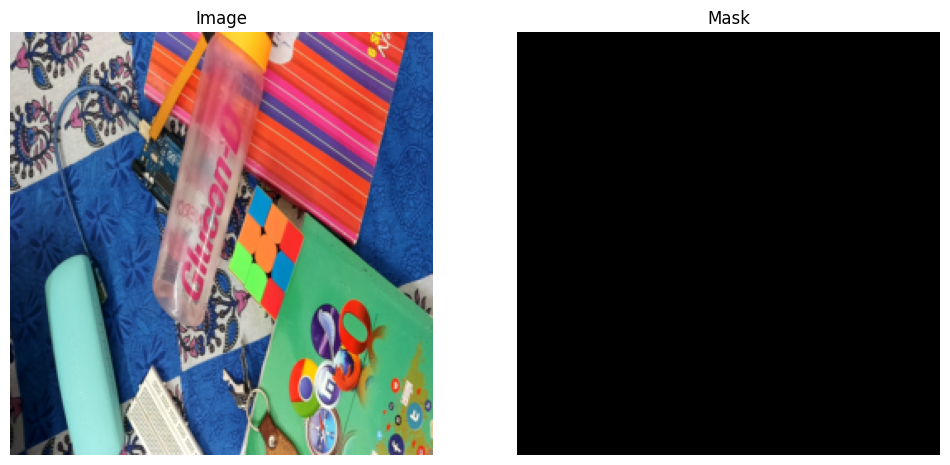

mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


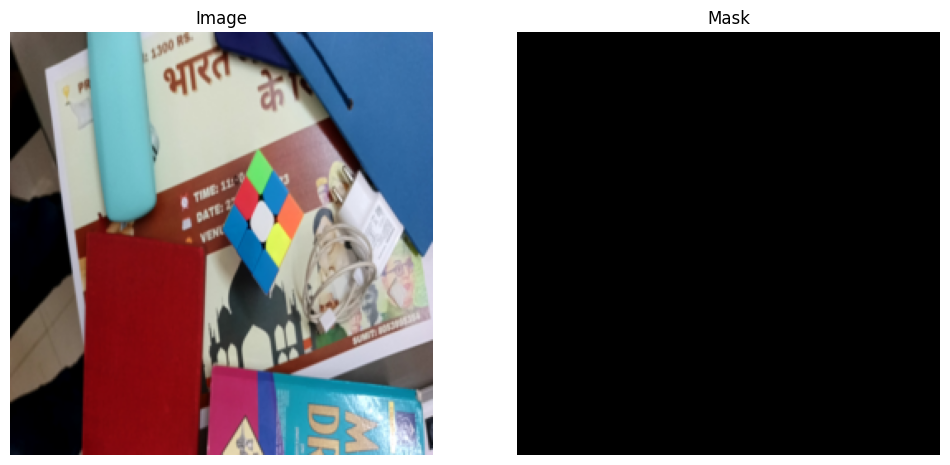

mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


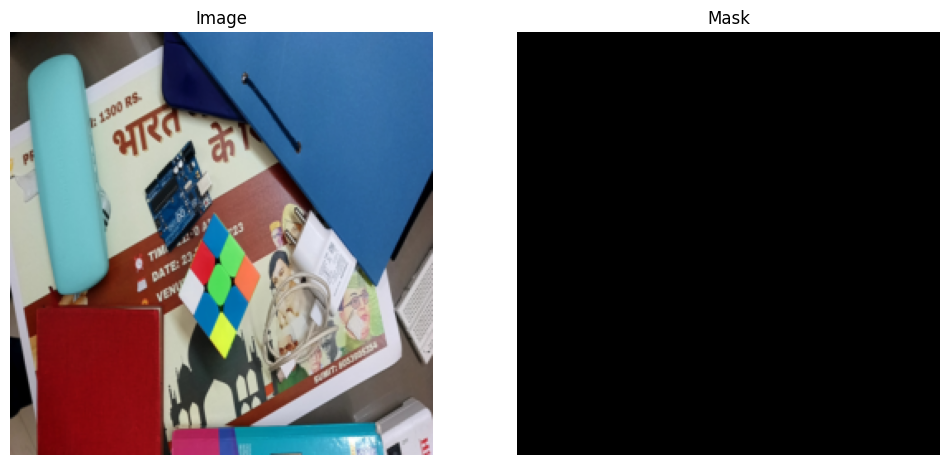

mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


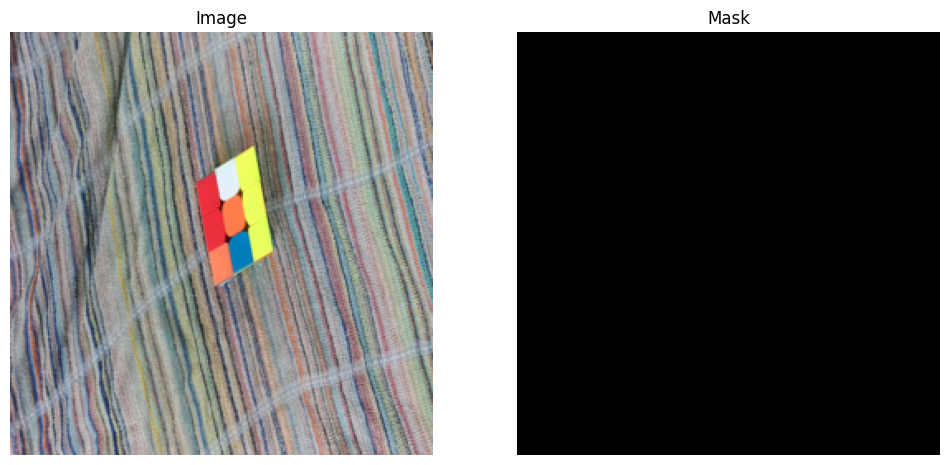

mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


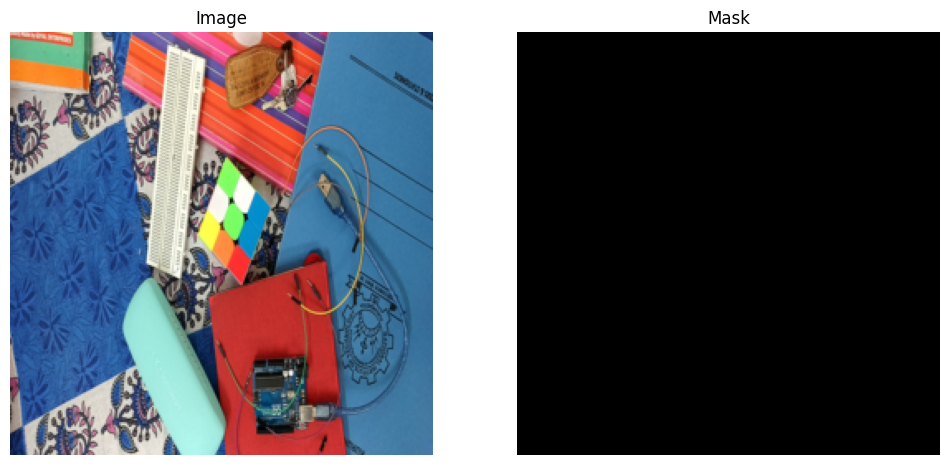

Visualizing testing samples...
mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


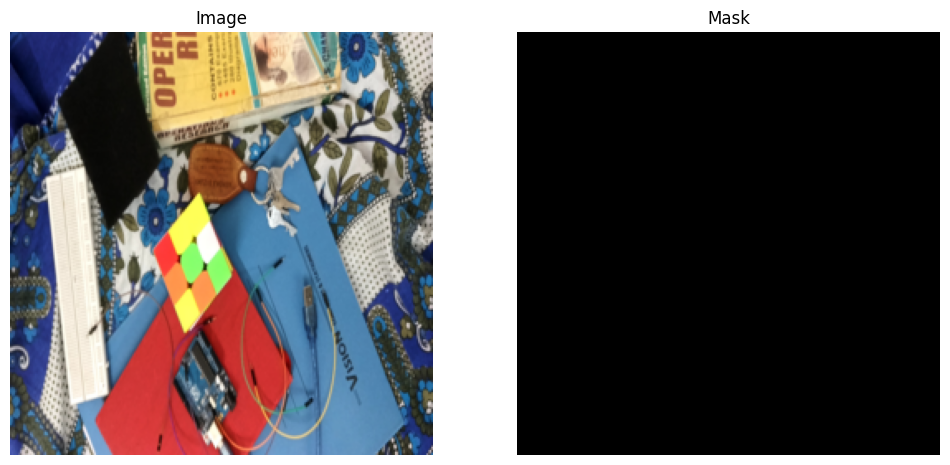

mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


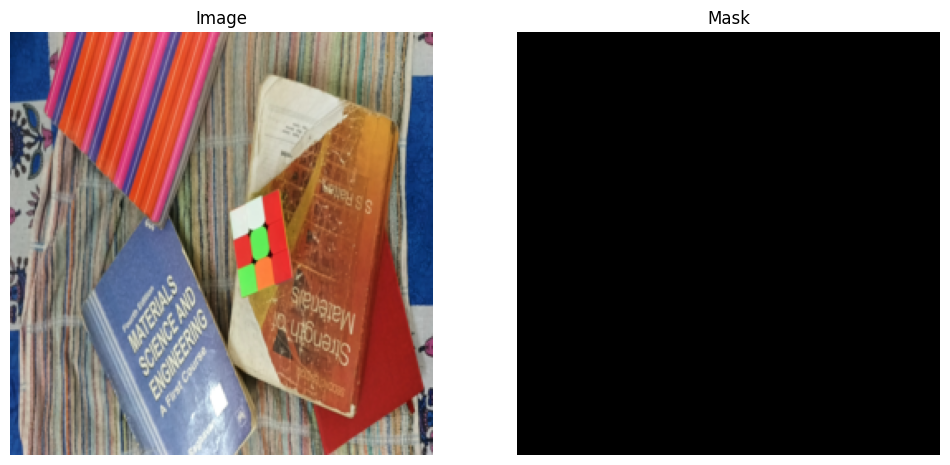

mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


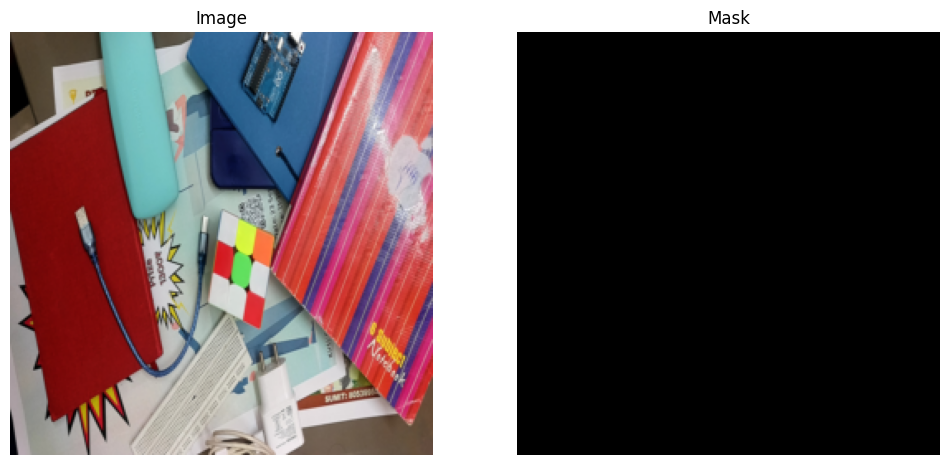

mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


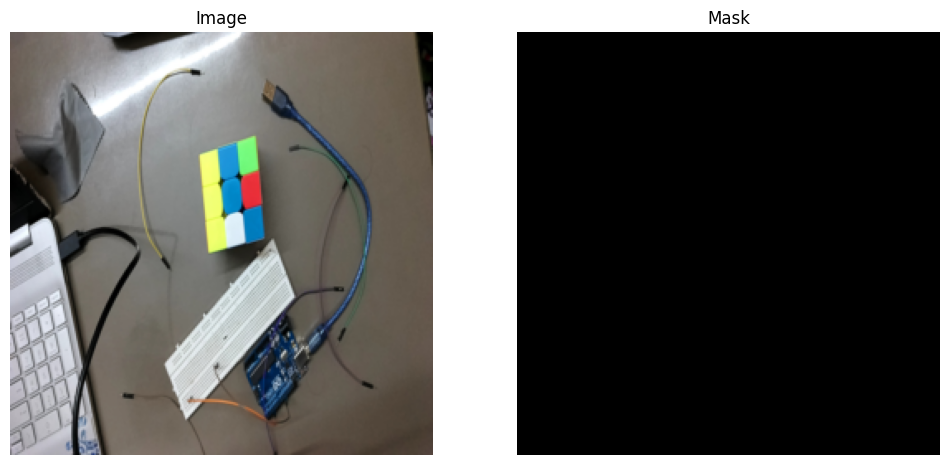

mask tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


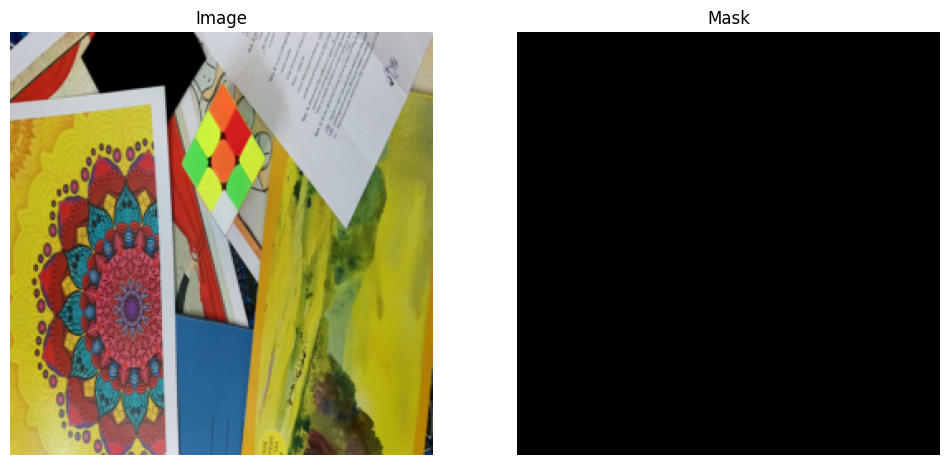

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
import re
import random

# Helper Function
def extract_number(filename):
    """
    Extracts the numerical part from a filename.
    For example, '2.jpg' returns 2.
    """
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        return -1  # Return -1 if no number is found

# Custom Dataset Class
class RubiksCubeDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        """
        Args:
            root_dir (string): Directory with 'images' and 'labels' folders.
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels')
        
        # List all image and label files
        image_files = [
            f for f in os.listdir(self.images_dir) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
        ]
        label_files = [
            f for f in os.listdir(self.labels_dir) 
            if f.lower().endswith('.txt')
        ]
        
        # Extract numbers and create dictionaries
        image_dict = {extract_number(f): f for f in image_files}
        label_dict = {extract_number(f): f for f in label_files}
        
        # Find common keys to ensure pairing
        common_keys = sorted(list(set(image_dict.keys()) & set(label_dict.keys())))
        
        if not common_keys:
            raise ValueError("No matching image and label files found.")
        
        # Create sorted lists based on numerical order
        self.image_files = [image_dict[k] for k in common_keys]
        self.label_files = [label_dict[k] for k in common_keys]
        
        self.transform = transform
        self.mask_transform = mask_transform
        
        print(f"Found {len(self.image_files)} image-label pairs.")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Get image and label filenames
        img_name = self.image_files[idx]
        label_name = self.label_files[idx]
        
        # Full paths
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, label_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        # Load and parse label
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        # Initialize mask
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = parts[0]
                if class_id != '0':
                    continue  # Skip other classes if any
                try:
                    # Parse YOLO format: class_id x_center y_center width height
                    x_center_norm, y_center_norm, box_width_norm, box_height_norm = map(float, parts[1:5])
                    
                    # Convert normalized coordinates to pixel values
                    x_center = int(x_center_norm * width)
                    y_center = int(y_center_norm * height)
                    box_width = int(box_width_norm * width)
                    box_height = int(box_height_norm * height)
                    
                    # Enforce square by taking the smaller dimension
                    min_dim = min(box_width, box_height)
                    half_min_dim = min_dim // 2
                    
                    # Calculate top-left and bottom-right coordinates for square
                    x1 = x_center - half_min_dim
                    y1 = y_center - half_min_dim
                    x2 = x_center + half_min_dim
                    y2 = y_center + half_min_dim
                    
                    # Ensure coordinates are within image boundaries
                    x1, x2 = max(0, min(x1, width - 1)), max(0, min(x2, width - 1))
                    y1, y2 = max(0, min(y1, height - 1)), max(0, min(y2, height - 1))
                    
                    # Draw filled square on mask
                    cv2.rectangle(mask, (x1, y1), (x2, y2), color=1, thickness=-1)
                except ValueError:
                    print(f"Invalid label format in file {label_name}: '{line}'")
            else:
                print(f"Incomplete label information in file {label_name}: '{line}'")
        
        # Convert mask to PIL Image
        mask = Image.fromarray(mask)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask

# Define Transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# Initialize Dataset
try:
    dataset = RubiksCubeDataset(
        root_dir='archive',  # Update this path if necessary
        transform=image_transforms,
        mask_transform=mask_transforms
    )
except ValueError as ve:
    print(ve)
    exit(1)

# Split into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Visualization Functions
def denormalize(image_tensor, mean, std):
    """
    Denormalizes a tensor image using mean and std.
    """
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

def visualize_samples(dataset, num_samples=5):
    """
    Visualizes a specified number of samples from the dataset.
    
    Args:
        dataset (Dataset): The dataset to visualize from.
        num_samples (int): Number of samples to visualize.
    """
    indices = random.sample(range(len(dataset)), num_samples)
    
    
    for idx in indices:
        image, mask = dataset[idx]
        print("mask", mask)
        
        # Denormalize image for visualization
        image_vis = denormalize(image.clone(), mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        image_vis = image_vis.permute(1, 2, 0).numpy()
        image_vis = np.clip(image_vis, 0, 1)
        
        # Convert mask to numpy
        mask_np = mask.squeeze().numpy()
        mask_np = (mask_np > 0.5).astype(np.float32)
        
        # Plotting
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.title('Image')
        plt.imshow(image_vis)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('Mask')
        plt.imshow(mask_np, cmap='gray')
        plt.axis('off')
        
        plt.show()

# Visualize samples from the training set
print("Visualizing training samples...")
visualize_samples(train_dataset, num_samples=5)

# Visualize samples from the testing set
print("Visualizing testing samples...")
visualize_samples(test_dataset, num_samples=5)

# Full code

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Dataset Class
class RubiksCubeDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels')
        self.image_files = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.jpg')])
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Load label
        label_name = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.labels_dir, label_name)
        with open(label_path, 'r') as f:
            lines = f.readlines()

        # Initialize mask
        mask = np.zeros((image.height, image.width), dtype=np.uint8)

        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5 and parts[0] == '0':
                # Assuming the format: 0 x1 y1 x2 y2
                x1, y1, x2, y2 = map(float, parts[1:5])
                # Convert normalized coordinates to pixels
                x1 = int(x1 * image.width)
                y1 = int(y1 * image.height)
                x2 = int(x2 * image.width)
                y2 = int(y2 * image.height)
                # Draw rectangle on mask
                cv2.rectangle(mask, (x1, y1), (x2, y2), color=1, thickness=-1)  # Filled rectangle

        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask

# Transforms
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# Initialize dataset and dataloaders
dataset = RubiksCubeDataset(root_dir='archive', transform=image_transforms, mask_transform=mask_transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# U-Net Model
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = CBR(n_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.center = CBR(512, 1024)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        
        self.final = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Center
        center = self.center(self.pool(enc4))
        
        # Decoder
        dec4 = self.up4(center)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.up3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.up2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.up1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        final = self.final(dec1)
        return torch.sigmoid(final)

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Testing
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {avg_test_loss:.4f}')

# Visualization
def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for idx in indices:
        image, mask = dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(image_input)
            pred = pred.squeeze().cpu().numpy()
            pred_mask = (pred > 0.5).astype(np.uint8)
        
        # Convert tensors to numpy
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = np.clip(image_np * np.array([0.229, 0.224, 0.225]) + 
                           np.array([0.485, 0.456, 0.406]), 0, 1)
        mask_np = mask.squeeze().cpu().numpy()
        
        # Plot
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(image_np)
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask')
        plt.imshow(mask_np, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
        
        plt.show()

# Run visualization
visualize_predictions(model, test_dataset, device, num_samples=5)

Using device: cpu


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ludvigeriksonbrangstrup/miniconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ludvigeriksonbrangstrup/miniconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'RubiksCubeDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ludvigeriksonbrangstrup/miniconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ludvigeriksonbrangstrup/miniconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
  

RuntimeError: DataLoader worker (pid(s) 58299) exited unexpectedly